In [1]:
from collections import defaultdict

import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset

In [2]:
DATASET_PATH = "combined-dataset.h5"
DEVICE = torch.device("cuda:1")
BATCH_SIZE = 256

print(f"Using device: {DEVICE}")

Using device: cuda:1


In [3]:
def move_to_device(batch):
    return tuple(item.to(DEVICE, non_blocking=True) for item in batch)

In [4]:
def augment_batch(depth, mask, quat):
    batch_size = depth.shape[0]

    # Gaussian noise
    if torch.rand(1).item() < 0.5:
        noise = torch.randn_like(depth) * 0.02
        depth = depth + noise

    # Scale variations
    if torch.rand(1).item() < 0.5:
        scales = torch.empty(batch_size, 1, 1, device=DEVICE).uniform_(0.95, 1.05)
        depth = depth * scales

    # Small per-sample offset
    if torch.rand(1).item() < 0.3:
        offsets = torch.empty(batch_size, 1, 1, device=DEVICE).uniform_(-0.03, 0.03)
        depth = depth + offsets

    depth = torch.clamp(depth, 0, 1)

    # Mask augmentation
    if torch.rand(1).item() < 0.4:
        mask_4d = mask.unsqueeze(1)
        if torch.rand(1).item() < 0.8:
            mask_4d = F.max_pool2d(mask_4d, 3, stride=1, padding=1)
        else:
            mask_4d = -F.max_pool2d(-mask_4d, 3, stride=1, padding=1)
        mask = mask_4d.squeeze(1)

    # Quaternion augmentation
    if torch.rand(1).item() < 0.5:
        angles = torch.empty(batch_size, device=DEVICE).uniform_(-0.175, 0.175)
        half_angles = angles / 2

        perturb_quats = torch.stack(
            [torch.cos(half_angles), torch.zeros_like(half_angles), torch.zeros_like(half_angles), torch.sin(half_angles)], dim=1
        )

        w1, x1, y1, z1 = perturb_quats.unbind(1)
        w2, x2, y2, z2 = quat.unbind(1)

        quat = torch.stack(
            [
                w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2,
                w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2,
                w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2,
                w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2,
            ],
            dim=1,
        )

        quat = F.normalize(quat, dim=1)

    return depth, mask, quat

In [5]:
class DistanceDataset(Dataset):
    def __init__(self):
        self._h5_file = None
        with h5py.File(DATASET_PATH, "r") as f:
            self.keys = list(f.keys())
            self.primitives = list(f.attrs["primitives"])
            self.depth_min = f.attrs["depth_min"]
            self.depth_max = f.attrs["depth_max"]
            self.dist_max = f.attrs["dist_max"]

    def _init_h5(self):
        if self._h5_file is None:
            self._h5_file = h5py.File(DATASET_PATH, "r")

    def close(self):
        if self._h5_file is not None:
            self._h5_file.close()
            self._h5_file = None

    def __del__(self):
        self.close()

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        self._init_h5()
        dp = self._h5_file[self.keys[idx]]
        return dp["depth"][()], dp["mask"][()], dp["dist_map"][()], dp["quat"][()], dp["feasibles"][()]


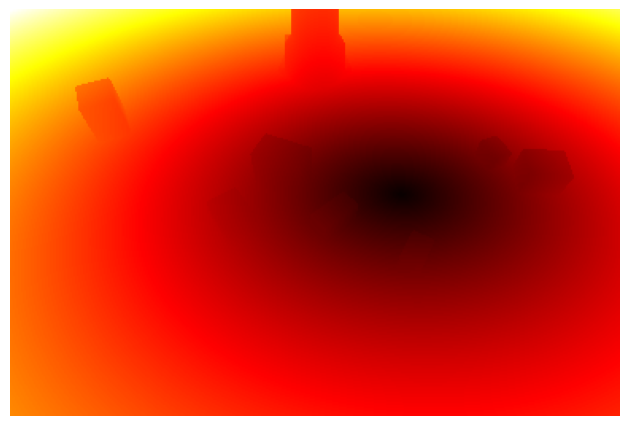

In [12]:
import matplotlib.pyplot as plt

dataset = DistanceDataset()

depth, mask, goal, quat, y = dataset[0]
plt.imshow(goal, cmap="hot")
plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
dataset = DistanceDataset()
primitives = dataset.primitives
num_primitives = len(primitives)

scene_to_indices = defaultdict(list)
for idx, key in enumerate(dataset.keys):
    scene_to_indices[key.rsplit("_obj_", 1)[0]].append(idx)
scene_ids = list(scene_to_indices.keys())


num_train = int(len(scene_ids) * 0.8)
num_val = int(len(scene_ids) * 0.1)
train_scenes = scene_ids[:num_train]
val_scenes = scene_ids[num_train : num_train + num_val]
test_scenes = scene_ids[num_train + num_val :]

train_indices = [idx for scene in train_scenes for idx in scene_to_indices[scene]]
val_indices = [idx for scene in val_scenes for idx in scene_to_indices[scene]]
test_indices = [idx for scene in test_scenes for idx in scene_to_indices[scene]]

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Total scenes: {len(scene_ids)}")
print(f"Train: {len(train_scenes)} scenes, {len(train_indices)} samples")
print(f"Val: {len(val_scenes)} scenes, {len(val_indices)} samples")
print(f"Test: {len(test_scenes)} scenes, {len(test_indices)} samples")
print(f"Sample shapes: {[item.shape for item in dataset[0]]}")

Total scenes: 10996
Train: 8796 scenes, 39784 samples
Val: 1099 scenes, 4915 samples
Test: 1101 scenes, 4995 samples
Sample shapes: [(256, 384), (256, 384), (256, 384), (4,), (8,)]


In [7]:
pos_counts = torch.zeros(num_primitives)
neg_counts = torch.zeros(num_primitives)
with h5py.File(DATASET_PATH, "r") as f:
    for key in dataset.keys:
        feasibles = torch.from_numpy(f[key]["feasibles"][()])
        pos_counts += feasibles
        neg_counts += 1 - feasibles
alpha = neg_counts / (pos_counts + neg_counts)
alpha = alpha.to(DEVICE)
print(f"Alpha: {alpha}")

Alpha: tensor([0.8307, 0.8268, 0.8255, 0.8309, 0.5378, 0.5309, 0.5987, 0.5940],
       device='cuda:1')


In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = (1 - pt) ** self.gamma
        alpha_weight = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        loss = alpha_weight * focal_weight * bce_loss
        return loss.mean()

In [9]:
def compute_metrics(probs: torch.Tensor, targets: torch.Tensor, threshold=0.5):
    preds = (probs > threshold).float()
    accuracy = (preds == targets).float().mean(dim=0)

    tp = (preds * targets).sum(dim=0)
    fp = (preds * (1 - targets)).sum(dim=0)
    fn = ((1 - preds) * targets).sum(dim=0)

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    prob_mean = probs.mean(dim=0)
    prob_std = probs.std(dim=0)

    return accuracy, precision, recall, f1, prob_mean, prob_std

In [10]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=(256, 384), patch_size=16, in_channels=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size, img_size[1] // patch_size)
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

        nn.init.trunc_normal_(self.proj.weight, std=0.02)
        nn.init.zeros_(self.proj.bias)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class ViT(nn.Module):
    def __init__(self, img_size=(256, 384), patch_size=16, in_channels=3, embed_dim=192, depth=4, num_heads=6, mlp_ratio=2.0, dropout=0.1):
        super().__init__()

        self.patch_embed = PatchEmbed(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=False,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self._init_transformer_weights()

        self.norm = nn.LayerNorm(embed_dim)

    def _init_transformer_weights(self):
        for module in self.transformer.modules():
            if isinstance(module, nn.Linear):
                nn.init.trunc_normal_(module.weight, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LayerNorm):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed
        x = self.transformer(x)
        x = self.norm(x)
        x = x[:, 0]
        return x


class DistanceViT(nn.Module):
    def __init__(self, img_size=(256, 384), patch_size=16, embed_dim=256, depth=6, num_heads=8):
        super().__init__()

        self.vision_encoder = ViT(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=3,
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            dropout=0.2,
        )

        self.quat_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.GELU(),
            nn.Dropout(0.2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_primitives),
        )

    def forward(self, depth, mask, goal, quat):
        vision_feat = self.vision_encoder(torch.stack([depth, mask, goal], dim=1))
        quat_feat = self.quat_encoder(quat)
        return self.classifier(torch.cat([vision_feat, quat_feat], dim=1))

In [11]:
model = DistanceViT().to(DEVICE)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

criterion = FocalLoss(alpha=alpha, gamma=2.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)
scheduler = OneCycleLR(optimizer, max_lr=2e-4, epochs=100, steps_per_epoch=len(train_loader), pct_start=0.2, anneal_strategy="cos")

Model parameters: 3,756,872


In [12]:
def check_grad_norms():
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            if grad_norm < 1e-7 or grad_norm > 5e-1:
                print(f"{name:50s} | grad_norm: {grad_norm:.2e}")


@torch.no_grad()
def debug_model():
    model.eval()
    batch = next(iter(train_loader))
    depth, mask, dist_map, quat, _ = move_to_device(batch)

    vision_input = torch.stack([depth, mask, dist_map], dim=1)
    B = vision_input.shape[0]

    patches = model.vision_encoder.patch_embed(vision_input)
    cls_tokens = model.vision_encoder.cls_token.expand(B, -1, -1)
    patches_with_cls = torch.cat([cls_tokens, patches], dim=1)
    patches_pos = patches_with_cls + model.vision_encoder.pos_embed
    transformed = model.vision_encoder.transformer(patches_pos)
    cls_output = transformed[:, 0]

    quat_feat = model.quat_encoder(quat)
    logits = model(depth, mask, dist_map, quat)

    depth_impact = (logits - model(torch.zeros_like(depth), mask, dist_map, quat)).abs().mean()
    mask_impact = (logits - model(depth, torch.zeros_like(mask), dist_map, quat)).abs().mean()
    dist_impact = (logits - model(depth, mask, torch.zeros_like(dist_map), quat)).abs().mean()
    quat_impact = (logits - model(depth, mask, dist_map, torch.zeros_like(quat))).abs().mean()

    patch_dead = (patches.abs() < 1e-5).float().mean()
    cls_dead = (cls_output.abs() < 1e-5).float().mean()
    quat_dead = (quat_feat.abs() < 1e-5).float().mean()

    patch_div = patches.std(dim=0).mean()
    cls_div = cls_output.std(dim=0).mean()

    print(
        f"impacts: d={depth_impact:.3f} m={mask_impact:.3f} "
        f"dist={dist_impact:.3f} q={quat_impact:.3f} | "
        f"std: patch={patches.std():.3f} cls={cls_output.std():.3f} "
        f"trans={transformed.std():.3f} quat={quat_feat.std():.3f} "
        f"logit={logits.std():.3f} | "
        f"dead: p={patch_dead:.2f} c={cls_dead:.2f} q={quat_dead:.2f} | "
        f"div: p={patch_div:.3f} c={cls_div:.3f}"
    )

In [13]:
def train():
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        depth, mask, goal, quat, y = move_to_device(batch)
        depth, mask, quat = augment_batch(depth, mask, quat)
        optimizer.zero_grad()
        logits = model(depth, mask, goal, quat)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * depth.size(0)
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def val():
    model.eval()
    val_loss = 0.0
    preds, targets = [], []
    for batch in val_loader:
        depth, mask, goal, quat, y = move_to_device(batch)
        pred = model(depth, mask, goal, quat)
        loss = criterion(pred, y)
        val_loss += loss.item() * depth.size(0)
        preds.append(pred)
        targets.append(y)
    return val_loss / len(val_loader.dataset), torch.cat(preds), torch.cat(targets)

In [ ]:
best_f1 = 0.0
patience = 5
patience_counter = 0
best_model_state = None

debug_model()

for epoch in range(100):
    lr = scheduler.get_last_lr()[0]
    train_loss = train()
    val_loss, logits, targets = val()

    print(f"epoch {epoch + 1:02d}: tL={train_loss:.4f} vL={val_loss:.4f} lr={lr:.2e}")

    acc, prec, rec, f1, prob_mean, prob_std = compute_metrics(logits.sigmoid(), targets)
    for i, primitive in enumerate(primitives):
        print(f"  {primitive:<12} A={acc[i]:.3f} P={prec[i]:.3f} R={rec[i]:.3f} F1={f1[i]:.3f} M={prob_mean[i]:.3f} S={prob_std[i]:.3f}")

    avg_f1 = f1.mean().item()
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        patience_counter = 0
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= patience:
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "val_loss": val_loss,
                "avg_f1": avg_f1,
            }

            torch.save(checkpoint, f"distance-model-{epoch}.pt")
            patience_counter = 0

    debug_model()
    check_grad_norms()

impacts: d=0.049 m=0.001 dist=0.026 q=0.005 | std: patch=0.189 cls=1.000 trans=1.000 quat=0.205 logit=0.082 | dead: p=0.00 c=0.00 q=0.00 | div: p=0.036 c=0.035
epoch 01: tL=0.0673 vL=0.0670 lr=8.00e-06
  push_x_pos   A=0.837 P=0.000 R=0.000 F1=0.000 M=0.492 S=0.001
  push_x_neg   A=0.176 P=0.176 R=1.000 F1=0.300 M=0.502 S=0.001
  push_y_pos   A=0.816 P=0.156 R=0.012 F1=0.022 M=0.498 S=0.001
  push_y_neg   A=0.799 P=0.140 R=0.040 F1=0.063 M=0.497 S=0.003
  lift_x       A=0.538 P=0.000 R=0.000 F1=0.000 M=0.496 S=0.002
  lift_y       A=0.557 P=0.683 R=0.132 F1=0.222 M=0.499 S=0.000
  pull_x       A=0.604 P=0.000 R=0.000 F1=0.000 M=0.495 S=0.000
  pull_y       A=0.447 P=0.422 R=0.893 F1=0.573 M=0.501 S=0.001
impacts: d=0.023 m=0.001 dist=0.029 q=0.004 | std: patch=0.189 cls=1.000 trans=1.000 quat=0.205 logit=0.013 | dead: p=0.00 c=0.00 q=0.00 | div: p=0.035 c=0.029
